In [ ]:
import pandas
import numpy
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifier


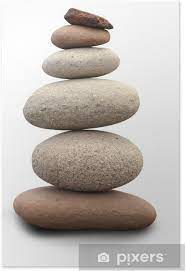


<h2> Stacking ! We collect all the train and test predicted files <h2>

<h4> Inspired by Craig Thomas Notebook. With my "weak" laptop, it is easier to tune, and train the first layer of algo with separate notebook (during the night). then I can upload the output files for the second layer (stacking). The more files you get the more improve the final score, but it is getting a bit boring and score should not be the main goal but learning :-) <h4>

In [ ]:
#each file is the output of a tuned model 

train1=pandas.read_csv('../input/mars-competition/xgb1_train_preds.csv',sep=';') # XGBM
train2=pandas.read_csv('../input/mars-competition/xgb2_train_preds.csv',sep=';') # XGBM
train3=pandas.read_csv('../input/mars-competition/lgb1_train_preds.csv',sep=';') # LGBM
train4=pandas.read_csv('../input/mars-competition/lgb2_train_preds.csv',sep=';') # LGBM
train5=pandas.read_csv('../input/mars-competition/cat_train_preds.csv',sep=';') # Catboost
train6=pandas.read_csv('../input/mars-competition/hist_train_preds.csv',sep=';') # HistGradientBoostingClassifier
train7=pandas.read_csv('../input/mars-competition/NHG_train_preds.csv',sep=';') # GradientBoostingClassifier

# We build a final train file 

l1_train=pandas.DataFrame()
l1_train['xgb1']=train1['0']
l1_train['xgb2']=train2['0']
l1_train['lgb1']=train3['0']
l1_train['lgb2']=train4['0']
l1_train['cat']=train5['0']
l1_train['hist']=train6['0']
l1_train['NHG']=train7['0']


# We build a final train file to fit. 

test1=pandas.read_csv('../input/mars-competition/xgb1_test_preds.csv',sep=';')
test2=pandas.read_csv('../input/mars-competition/xgb2_test_preds.csv',sep=';')
test3=pandas.read_csv('../input/mars-competition/lgb1_test_preds.csv',sep=';')
test4=pandas.read_csv('../input/mars-competition/lgb2_test_preds.csv',sep=';')
test5=pandas.read_csv('../input/mars-competition/cat_test_preds.csv',sep=';')
test6=pandas.read_csv('../input/mars-competition/hist_test_preds.csv',sep=';')
test7=pandas.read_csv('../input/mars-competition/NHG_test_preds.csv',sep=';')

# We build a validation file from the test prediction of each model.

l1_test=pandas.DataFrame()
l1_test['xgb1']=test1['0']
l1_test['xgb2']=test2['0']
l1_test['lgb1']=test3['0']
l1_test['lgb2']=test4['0']
l1_test['cat']=test5['0']
l1_test['hist']=test6['0']
l1_test['NHG']=test7['0']


target=pandas.read_csv('../input/marscompetition/1y.csv')
display(l1_train.dtypes,l1_train.head(3))
display(l1_test.dtypes,l1_test.head(3))

train_preds = numpy.zeros(len(l1_train.index), )
test_preds = numpy.zeros(len(l1_test.index), )


<h2> META MODEL <h2>

In [ ]:
random_state = 2021
n_folds = 15
k_fold = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)

for fold, (train_index, test_index) in enumerate(k_fold.split(l1_train, target)):
    print("--> Fold {}".format(fold + 1))
   
    x_train = pandas.DataFrame(l1_train.iloc[train_index])
    y_train = target.iloc[train_index]
    
    x_valid = pandas.DataFrame(l1_train.iloc[test_index])
    y_valid = target.iloc[test_index]
    
    model = CalibratedClassifierCV(RidgeClassifier(random_state=random_state),cv=3)
    model.fit(x_train,y_train)

    train_oof_preds = model.predict_proba(x_valid)[:,-1]
    test_oof_preds = model.predict_proba(l1_test)[:,-1] # test prediction for the fold
    
    train_preds[test_index] = train_oof_preds # We need it to measure the AUC score of the fold
    test_preds += test_oof_preds / n_folds    # We get test prediction for the current fold 
                                              # (For the final test file we need /n_folds X n_folds = 1)
    
    print(": ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))
    print("")
    
print("--> Overall metrics")
print(": ROC AUC Score = {}".format(roc_auc_score(target, train_preds, average="micro")))

In [ ]:
test_preds[:5]

In [ ]:
submission = pandas.read_csv("../input/tabular-playground-series-mar-2021/sample_submission.csv")

In [ ]:
submission["target"] = test_preds

In [ ]:
submission.to_csv("./submission25.csv",index=False)